# HAND-CLAMP

## 3. Experiments

### 3-2. Modeling

#### 3-2-2. Trials & Choices

In [10]:
%cd /home/jupyter/CLAMP_hand

/home/jupyter/CLAMP_hand


##### 3-2-2-1. Trial 1 (Base Model)

##### (1) Batch Size: 16
##### (2) Epoch: 210
##### (3) Optimizer: 'Adam'
##### (4) Learning Rate: 5e-4
##### (5) Weight Decay: 0.0001

```jsx
_base_ = ['../../../../_base_/datasets/interhand_onehand.py']
log_level = 'INFO'
load_from = None
resume_from = None
dist_params = dict(backend='nccl')
workflow = [('train', 1)]
checkpoint_config = dict(interval=10)
evaluation = dict(interval=10, metric='mAP', save_best='AP')

optimizer = dict(type='Adam',                                                                                                                    (3) Optimizer: 'Adam'
                 lr=5e-4,                                                                                                                        (4) Learning Rate: 5e-4
                 weight_decay=0.0001,                                                                                                            (5) Weight Decay: 0.0001
                 paramwise_cfg=dict(custom_keys={'text_encoder': dict(lr_mult=0.0),
                                                 'backbone': dict(lr_mult=0.1),
                                                 'norm': dict(decay_mult=0.)})
)
optimizer_config = dict(grad_clip=None)
# learning policy
lr_config = dict(
    policy='step',
    warmup='linear',
    warmup_iters=500,
    warmup_ratio=0.001,
    step=[170, 200])
total_epochs = 210                                                                                                                                      (2) Epoch: 210
log_config = dict(
    interval=1,
    hooks=[
        dict(type='TextLoggerHook'),
    ])

channel_cfg = dict(
    num_output_channels=21,
    dataset_joints=21,
    dataset_channel=[
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    ],
    inference_channel=[
        0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20
    ])

# model settings
model = dict(
    type='CLAMP',
    clip_pretrained='pretrained/ViT-B-16.pt',
    context_length=11,
    text_dim=512,
    score_concat_index=3,
    visual_dim=512,
    CL_ratio=0.0005,
    class_names=['thumb tip', 'thumb proximal joint', 'thumb intermediate joint', 'thumb base joint',
                'index tip', 'index proximal joint', 'index intermediate joint', 'index base joint',
                'middle tip', 'middle proximal joint', 'middle intermediate joint', 'middle base joint',
                'ring tip', 'ring proximal joint', 'ring intermediate joint', 'ring base joint',
                'little tip', 'little proximal joint', 'little intermediate joint', 'little base joint',
                'wrist'],
    text_encoder=dict(
        type='CLIPTextContextEncoder',
        context_length=13,
        embed_dim=512,
        transformer_width=512,
        transformer_heads=8,
        transformer_layers=12,
        pretrained='pretrained/ViT-B-16.pt',
        style='pytorch'),
    prompt_encoder=dict(
        type='PromptEncoderWithoutPositionemb',
        prompt_num=21,
        transformer_width=512,
        transformer_heads=8,
        transformer_layers=1,
        embed_dim=512,
        style='pytorch'),
    context_decoder=dict(
        type='ContextDecoder',
        transformer_width=256,
        transformer_heads=4,
        transformer_layers=3,
        visual_dim=512,
        dropout=0.1,
        outdim=512,
        style='pytorch'),
    backbone=dict(
        type='CLIPVisionTransformer',
        debug=False,
        use_fpn=False,
        patch_size=16,
        width=768,
        output_dim=512,
        get_embeddings=True,
        drop_path_rate=0.4,
        layers=12,
        input_resolution=256,
        style='pytorch'),
    keypoint_head=dict(
        type='TopdownHeatmapSimpleHead',
        num_deconv_layers=2,
        num_deconv_filters=(256, 256),
        num_deconv_kernels=(4, 4),
        in_channels=789, #768+21
        out_channels=channel_cfg['num_output_channels'],
        loss_keypoint=dict(type='JointsMSELoss', use_target_weight=True, loss_weight=1.0)),
    upconv_head=dict( #for score map only
        type='TopdownHeatmapSimpleHead',
        num_deconv_layers=2,
        num_deconv_filters=(21, 21),
        num_deconv_kernels=(4, 4),
        in_channels=21,
        out_channels=channel_cfg['num_output_channels'],
        loss_keypoint=dict(type='JointsMSELoss', use_target_weight=True, loss_weight=2.0)),
    identity_head=dict(
        type='IdentityHead',
        loss_keypoint=dict(type='JointsMSELoss', use_target_weight=True, loss_weight=2.0)),
    train_cfg=dict(),
    test_cfg=dict(
        flip_test=True,
        post_process='default',
        shift_heatmap=True,
        modulate_kernel=11))

data_cfg = dict(
    image_size=[256, 256],
    heatmap_size=[64, 64],
    num_output_channels=channel_cfg['num_output_channels'],
    num_joints=channel_cfg['dataset_joints'],
    dataset_channel=channel_cfg['dataset_channel'],
    inference_channel=channel_cfg['inference_channel'],
    soft_nms=False,
    nms_thr=1.0,
    oks_thr=0.9,
    vis_thr=0.2,
    use_gt_bbox=True,
    det_bbox_thr=0.0,
    bbox_file='',
)

train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='TopDownRandomFlip', flip_prob=0.5),
    dict(
        type='TopDownHalfBodyTransform',
        num_joints_half_body=8,
        prob_half_body=0.3),
    dict(
        type='TopDownGetRandomScaleRotation', rot_factor=40, scale_factor=0.5),
    dict(type='TopDownAffine'),
    dict(type='ToTensor'),
    dict(
        type='NormalizeTensor',
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]),
    dict(type='TopDownGenerateTarget', sigma=2, downtarget=True, downsize=16),
    dict(
        type='Collect',
        keys=['img', 'target', 'target_weight'],
        meta_keys=[
            'image_file', 'joints_3d', 'joints_3d_visible', 'center', 'scale',
            'rotation', 'bbox_score', 'flip_pairs'
        ]),
]

val_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='TopDownAffine'),
    dict(type='ToTensor'),
    dict(
        type='NormalizeTensor',
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]),
    dict(
        type='Collect',
        keys=['img'],
        meta_keys=[
            'image_file', 'center', 'scale', 'rotation', 'bbox_score',
            'flip_pairs'
        ]),
]

test_pipeline = val_pipeline

data_root = 'data/hands'
data = dict(
    samples_per_gpu=16,                                                                                                                           (1) Batch Size: 16
    workers_per_gpu=4,
    val_dataloader=dict(samples_per_gpu=16),
    test_dataloader=dict(samples_per_gpu=16),
    persistent_workers=True,
    pin_memory=False,
    train=dict(
        type='AnimalAP10KDataset',
        ann_file=f'{data_root}/annotations/assemblyhands_train_ego_data_v1-1_onehand.json',
        img_prefix=f'{data_root}/data/',
        data_cfg=data_cfg,
        pipeline=train_pipeline,
        dataset_info={{_base_.dataset_info}}),
    val=dict(
        type='AnimalAP10KDataset',
        ann_file=f'{data_root}/annotations/assemblyhands_val_ego_data_v1-1_onehand.json',
        img_prefix=f'{data_root}/data/',
        data_cfg=data_cfg,
        pipeline=val_pipeline,
        dataset_info={{_base_.dataset_info}}),
    test=dict(
        type='AnimalAP10KDataset',
        ann_file=f'{data_root}/annotations/assemblyhands_test_ego_data_v1-1_onehand.json',
        img_prefix=f'{data_root}/data/',
        data_cfg=data_cfg,
        pipeline=val_pipeline,
        dataset_info={{_base_.dataset_info}}),
)
```

##### Train model

!bash tools/dist_train.sh configs/animal/2d_kpt_sview_rgb_img/topdown_heatmap/ap10k/CLAMP_ViTB_ap10k_256x256_onehand.py 1 "0"

##### Save weight files in the path (CLAMP_hand/work_dirs/CLAMP_ViTB_ap10k_256x256)

##### Test model

In [3]:
for i in range(10, 220, 10):
    !bash tools/dist_test.sh configs/animal/2d_kpt_sview_rgb_img/topdown_heatmap/ap10k/CLAMP_ViTB_ap10k_256x256_onehand.py work_dirs/CLAMP_ViTB_ap10k_256x256/epoch_{i}.pth 1 "0"

/home/jupyter/CLAMP/mmcv/mmcv/cnn/bricks/transformer.py:28: UserWarning: Fail to import ``MultiScaleDeformableAttention`` from ``mmcv.ops.multi_scale_deform_attn``, You should install ``mmcv-full`` if you need this module. 
  warnings.warn('Fail to import ``MultiScaleDeformableAttention`` from '
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
=> num_images: 500
=> load 500 samples
Resize the pos_embed shape from torch.Size([197, 768]) to torch.Size([257, 768])
/opt/conda/envs/clamp/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
[] [] are misaligned params in vision transformer
positional_embedding is tuncated from 77 to 13
[] [] are misaligned params in te

##### Draw hand pictures (Quantitative Performance)

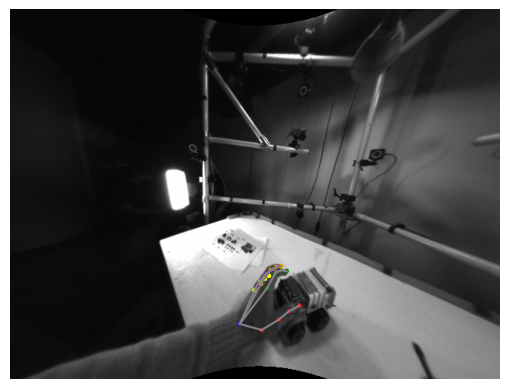

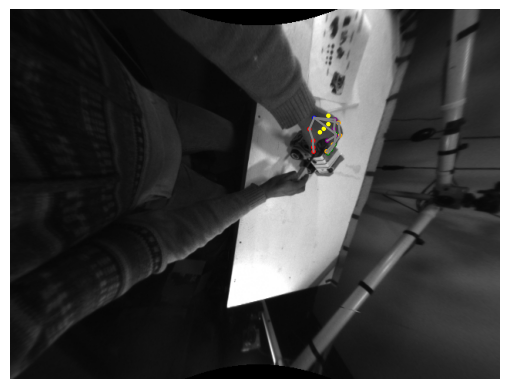

In [19]:
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

def visualize_keypoints(json_file_path, image_path, image_number):
    with open(json_file_path, 'r') as f:
        data = json.load(f)

    # Select data from 'json_file' based on image_number
    keypoints_info = data[image_number]
    
    keypoints = keypoints_info["keypoints"]
    center = keypoints_info["center"]
    scale = keypoints_info["scale"]

    # Load the image
    image = plt.imread(image_path)

    # Create a plot
    plt.imshow(image)
    plt.axis('off')

    # Plot keypoints on the image
    for i, j in zip(range(0, 63, 3), range(0, 63)):
        x, y, score = keypoints[i], keypoints[i + 1], keypoints[i + 2]

        color_cycle = ['red', 'green', 'orange', 'purple', 'yellow', 'blue']
        color = color_cycle[j // 4]

        circle1 = Circle((x, y), radius=2, color=color)
        plt.gca().add_patch(circle1)

    # Skeleton connections based on skeleton_info
    skeleton_info = [
        [1, 2],
        [2, 3],
        [3, 4],
        [4, 21],
        [5, 6],
        [6, 7],
        [7, 8],
        [8, 21],
        [9, 10],
        [10, 11],
        [11, 12],
        [12, 21],
        [13, 14],
        [14, 15],
        [15, 16],
        [16, 21]
    ]

    for connection in skeleton_info:
        start_idx, end_idx = connection
        start_x, start_y, _ = keypoints[(start_idx - 1) * 3: start_idx * 3]
        end_x, end_y, _ = keypoints[(end_idx - 1) * 3: end_idx * 3]
        plt.plot([start_x, end_x], [start_y, end_y], color='gray')

    # Set the aspect ratio and display the plot
    plt.gca().set_aspect('equal')
    plt.show()

# JSON file path
json_file_path = "work_dirs/CLAMP_ViTB_ap10k_256x256_onehand/result_keypoints_210epoch.json"

# Image paths and their corresponding image numbers
image_paths = [
    ("data/hands/data/ego_images_rectified/val/nusar-2021_action_both_9012-c07c_9012_user_id_2021-02-01_164345/HMC_84346135_mono10bit/000890.jpg", 5),
    ("data/hands/data/ego_images_rectified/val/nusar-2021_action_both_9012-c07c_9012_user_id_2021-02-01_164345/HMC_84355350_mono10bit/000660.jpg", 320)
]

# Visualize the keypoints and skeleton for each image
for image_path, image_number in image_paths:
    visualize_keypoints(json_file_path, image_path, image_number)

##### Draw plot of accuracy (AP, AR)

##### Average Precision(AP): AP is a metric used to evaluate the accuracy of object detection algorithms by calculating the area under the precision-recall curve.
##### Average Recall(AR): AR is a metric used in object detection to assess the ability of a model to find all relevant instances of objects in a dataset, averaged over different recall levels.

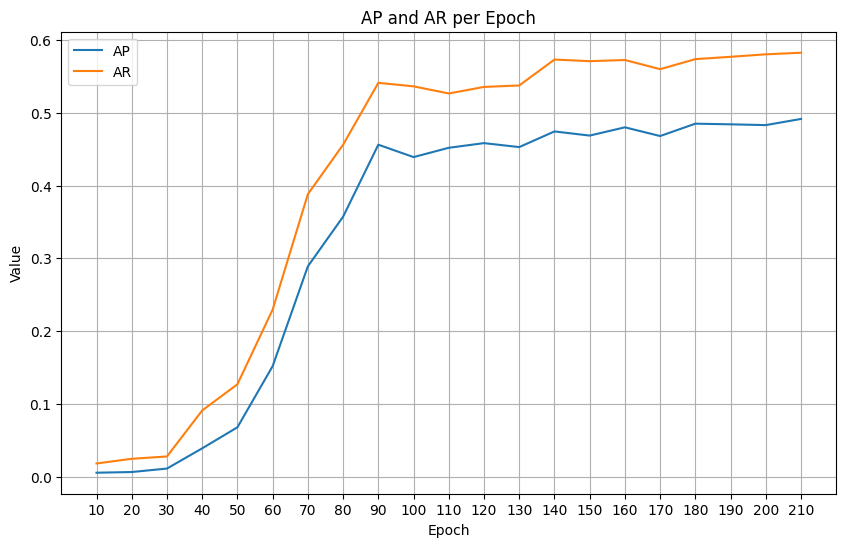

In [8]:
import matplotlib.pyplot as plt

accuracy = {
    0: {'AP': 0.005466591186095684, 'AR': 0.0182},
    1: {'AP': 0.006418164861306761, 'AR': 0.0246},
    2: {'AP': 0.011183339720996756, 'AR': 0.0278},
    3: {'AP': 0.038976264881516794, 'AR': 0.091},
    4: {'AP': 0.06789022185261682, 'AR': 0.127},
    5: {'AP': 0.1518906936685896, 'AR': 0.22959999999999994},
    6: {'AP': 0.28908806848638835, 'AR': 0.3882},
    7: {'AP': 0.3572666721745433, 'AR': 0.45619999999999994},
    8: {'AP': 0.45621352179727725, 'AR': 0.5412},
    9: {'AP': 0.43918527482837694, 'AR': 0.5364},
    10: {'AP': 0.4519655951373364, 'AR': 0.5266},
    11: {'AP': 0.4583798887585499, 'AR': 0.5356},
    12: {'AP': 0.45291806849332683, 'AR': 0.5376},
    13: {'AP': 0.4744372329194673, 'AR': 0.5732},
    14: {'AP': 0.4687443439943313, 'AR': 0.571},
    15: {'AP': 0.4800958447853976, 'AR': 0.5726},
    16: {'AP': 0.4681024303617787, 'AR': 0.56},
    17: {'AP': 0.48510630142718425, 'AR': 0.5738},
    18: {'AP': 0.4842110702226697, 'AR': 0.577},
    19: {'AP': 0.4831393123347249, 'AR': 0.5803999999999999},
    20: {'AP': 0.49162241543490515, 'AR': 0.5826}
}

ap_values = []
ar_values = []

for epoch in accuracy:
    ap_values.append(accuracy[epoch]['AP'])
    ar_values.append(accuracy[epoch]['AR'])

epochs = range(len(accuracy))

plt.figure(figsize=(10, 6))

plt.plot(epochs, ap_values, label='AP')
plt.plot(epochs, ar_values, label='AR')

plt.title('AP and AR per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.xticks([i for i in range(0, len(accuracy), 1)], [(i+1) * 10 for i in range(0, len(accuracy), 1)])
plt.show()

##### Draw plot of the loss (MPJPE 2D pixel error)

##### MPJPE(2D pixel error in CLAMP) : Mean per joint position error = Mean of per joint position error for all k joints
##### Mean per joint position error = Euclidean distance between ground truth and prediction for a joint

Pixel 2D: 23.338647061412146
Pixel 2D: 21.14880381962511
Pixel 2D: 21.673063939317732
Pixel 2D: 17.882499754673084
Pixel 2D: 16.860651813342855
Pixel 2D: 13.281624136084561
Pixel 2D: 10.46085193585479
Pixel 2D: 9.608316141153157
Pixel 2D: 8.185821842775697
Pixel 2D: 8.298186051524898
Pixel 2D: 8.50938806931975
Pixel 2D: 8.18941391782044
Pixel 2D: 8.399164383712849
Pixel 2D: 7.703199289072167
Pixel 2D: 7.719502134071812
Pixel 2D: 7.754724818570429
Pixel 2D: 7.768087781703276
Pixel 2D: 7.622406262970197
Pixel 2D: 7.651723163151591
Pixel 2D: 7.619749168445561
Pixel 2D: 7.596086522876228


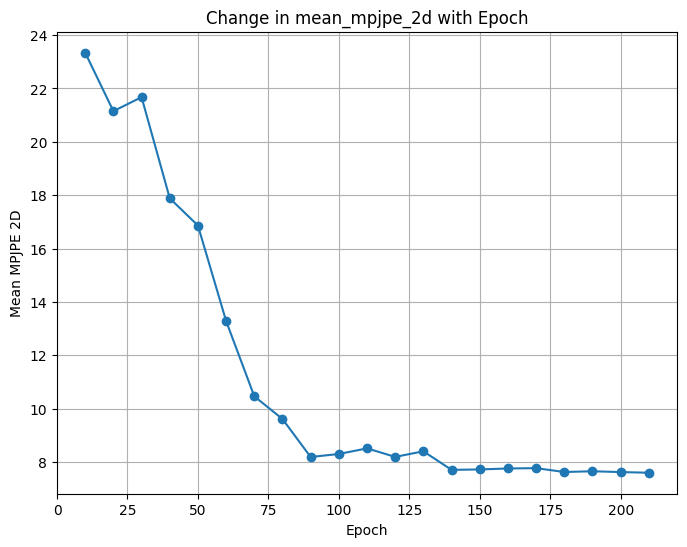

In [15]:
import json
import numpy as np
import torch

# Actual file path
actual_json_file_path = "data/hands/annotations/assemblyhands_val_ego_data_v1-1_onehand.json"

epochs = []
mean_mpjpe_2d_values = []

for i in range(10, 220, 10):
    # Predicted file path
    predicted_json_file_path = f"work_dirs/CLAMP_ViTB_ap10k_256x256_onehand/result_keypoints_{i}epoch.json"

    # Load actual and predicted skeleton points from JSON files
    with open(actual_json_file_path, 'r') as f:
        actual_data = json.load(f)

    with open(predicted_json_file_path, 'r') as f:
        predicted_data = json.load(f)

    # Initialize arrays to store results
    mpjpe_2d_values = []

    for entry_idx in range(len(actual_data["annotations"])):
        actual_skeleton = np.array(actual_data["annotations"][entry_idx]["keypoints"])
        predicted_skeleton = np.array(predicted_data[entry_idx]["keypoints"])

        actual_skeleton = actual_skeleton.reshape((-1, 21, 3))
        predicted_skeleton = predicted_skeleton.reshape((-1, 21, 3))

        actual_skeleton_tensor = torch.tensor(actual_skeleton)
        predicted_skeleton_tensor = torch.tensor(predicted_skeleton)

        excluded_indices = torch.where((actual_skeleton_tensor == -1.0000e+05).any(dim=2))[1]

        num_joints = list(range(actual_skeleton_tensor.size(1)))
        nouse_joints = list(excluded_indices.numpy())
        use_joints = [item for item in num_joints if item not in nouse_joints]

        actual_skeleton_tensor = actual_skeleton_tensor[:, use_joints, :]
        predicted_skeleton_tensor = predicted_skeleton_tensor[:, use_joints, :]

        uv_errors = torch.sqrt(((predicted_skeleton_tensor - actual_skeleton_tensor)[:, :, :2] ** 2).sum(dim=-1)).mean(dim=-1).cpu().numpy()
        mpjpe_2d = np.mean(uv_errors)
        mpjpe_2d_values.append(mpjpe_2d)

    # Calculate and print the overall metrics
    mean_mpjpe_2d = np.mean(mpjpe_2d_values)
    print("Pixel 2D:", mean_mpjpe_2d)
    
    epochs.append(i)
    mean_mpjpe_2d_values.append(mean_mpjpe_2d)
    
plt.figure(figsize=(8, 6))
plt.plot(epochs, mean_mpjpe_2d_values, marker='o', linestyle='-')
plt.title('Change in mean_mpjpe_2d with Epoch')
plt.xlabel('Epoch')
plt.ylabel('Mean MPJPE 2D')
plt.grid(True)
plt.show()

##### Result of Trial 1
##### For epoch 210, the accuracy (AP, AR) and the loss (Pixel 2D error) are the best.

weight file: change file name 'epoch_210' to 'epoch_210_onehand_Adam_16'

##### 3-2-2-2. Trial 2 (Hyperparameter Tuning)

##### My team will adjust hyperparameters (Optimizer, Batch size)
##### (1) Optimizer: Adam, AdamW
##### (2) Batch Size: 8, 16

##### Optimizer Explanation
##### Adam: Weight decay is incorporated within the optimization process, affecting the update of the weights directly.
##### AdamW: It explicitly separates the weight decay from the optimization step, making it potentially more stable during training.

##### Trial 2-1
##### (1) Optimizer: Adam
##### (2) Batch Size: 8

```python
optimizer = dict(type='Adam', # set optimizer Adam
                 lr=5e-4,
                 weight_decay=0.0001,
                 paramwise_cfg=dict(custom_keys={'text_encoder': dict(lr_mult=0.0),
                                                 'backbone': dict(lr_mult=0.1),
                                                 'norm': dict(decay_mult=0.)})
)
samples_per_gpu=8, # set batch size 8
workers_per_gpu=4,
val_dataloader=dict(samples_per_gpu=8),
test_dataloader=dict(samples_per_gpu=8)
```

In [16]:
!bash tools/dist_test.sh configs/animal/2d_kpt_sview_rgb_img/topdown_heatmap/ap10k/CLAMP_ViTB_ap10k_256x256_onehand.py work_dirs/CLAMP_ViTB_ap10k_256x256/epoch_210_onehand_Adam_8.pth 1 "0"

/home/jupyter/CLAMP/mmcv/mmcv/cnn/bricks/transformer.py:28: UserWarning: Fail to import ``MultiScaleDeformableAttention`` from ``mmcv.ops.multi_scale_deform_attn``, You should install ``mmcv-full`` if you need this module. 
  warnings.warn('Fail to import ``MultiScaleDeformableAttention`` from '
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
=> num_images: 500
=> load 500 samples
Resize the pos_embed shape from torch.Size([197, 768]) to torch.Size([257, 768])
/opt/conda/envs/clamp/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
[] [] are misaligned params in vision transformer
positional_embedding is tuncated from 77 to 13
[] [] are misaligned params in te

```python
optimizer = dict(type='Adam', # set optimizer Adam
                 lr=5e-4,
                 weight_decay=0.0001,
                 paramwise_cfg=dict(custom_keys={'text_encoder': dict(lr_mult=0.0),
                                                 'backbone': dict(lr_mult=0.1),
                                                 'norm': dict(decay_mult=0.)})
)
samples_per_gpu=16, # set batch size 16
workers_per_gpu=4,
val_dataloader=dict(samples_per_gpu=16),
test_dataloader=dict(samples_per_gpu=16)
```

In [17]:
!bash tools/dist_test.sh configs/animal/2d_kpt_sview_rgb_img/topdown_heatmap/ap10k/CLAMP_ViTB_ap10k_256x256_onehand.py work_dirs/CLAMP_ViTB_ap10k_256x256/epoch_210_onehand_Adam_16.pth 1 "0"

/home/jupyter/CLAMP/mmcv/mmcv/cnn/bricks/transformer.py:28: UserWarning: Fail to import ``MultiScaleDeformableAttention`` from ``mmcv.ops.multi_scale_deform_attn``, You should install ``mmcv-full`` if you need this module. 
  warnings.warn('Fail to import ``MultiScaleDeformableAttention`` from '
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
=> num_images: 500
=> load 500 samples
Resize the pos_embed shape from torch.Size([197, 768]) to torch.Size([257, 768])
/opt/conda/envs/clamp/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
[] [] are misaligned params in vision transformer
positional_embedding is tuncated from 77 to 13
[] [] are misaligned params in te

```python
optimizer = dict(type='AdamW', # set optimizer AdamW
                 lr=5e-4,
                 weight_decay=0.0001,
                 paramwise_cfg=dict(custom_keys={'text_encoder': dict(lr_mult=0.0),
                                                 'backbone': dict(lr_mult=0.1),
                                                 'norm': dict(decay_mult=0.)})
)
samples_per_gpu=8, # set batch size 8
workers_per_gpu=4,
val_dataloader=dict(samples_per_gpu=8),
test_dataloader=dict(samples_per_gpu=8)
```

In [18]:
!bash tools/dist_test.sh configs/animal/2d_kpt_sview_rgb_img/topdown_heatmap/ap10k/CLAMP_ViTB_ap10k_256x256_onehand.py work_dirs/CLAMP_ViTB_ap10k_256x256/epoch_210_onehand_AdamW_8.pth 1 "0"

/home/jupyter/CLAMP/mmcv/mmcv/cnn/bricks/transformer.py:28: UserWarning: Fail to import ``MultiScaleDeformableAttention`` from ``mmcv.ops.multi_scale_deform_attn``, You should install ``mmcv-full`` if you need this module. 
  warnings.warn('Fail to import ``MultiScaleDeformableAttention`` from '
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
=> num_images: 500
=> load 500 samples
Resize the pos_embed shape from torch.Size([197, 768]) to torch.Size([257, 768])
/opt/conda/envs/clamp/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
[] [] are misaligned params in vision transformer
positional_embedding is tuncated from 77 to 13
[] [] are misaligned params in te

```python
optimizer = dict(type='AdamW', # set optimizer AdamW
                 lr=5e-4,
                 weight_decay=0.0001,
                 paramwise_cfg=dict(custom_keys={'text_encoder': dict(lr_mult=0.0),
                                                 'backbone': dict(lr_mult=0.1),
                                                 'norm': dict(decay_mult=0.)})
)
samples_per_gpu=16, # set batch size 16
workers_per_gpu=4,
val_dataloader=dict(samples_per_gpu=16),
test_dataloader=dict(samples_per_gpu=16)
```

In [19]:
!bash tools/dist_test.sh configs/animal/2d_kpt_sview_rgb_img/topdown_heatmap/ap10k/CLAMP_ViTB_ap10k_256x256_onehand.py work_dirs/CLAMP_ViTB_ap10k_256x256/epoch_210_onehand_AdamW_16.pth 1 "0"

/home/jupyter/CLAMP/mmcv/mmcv/cnn/bricks/transformer.py:28: UserWarning: Fail to import ``MultiScaleDeformableAttention`` from ``mmcv.ops.multi_scale_deform_attn``, You should install ``mmcv-full`` if you need this module. 
  warnings.warn('Fail to import ``MultiScaleDeformableAttention`` from '
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
=> num_images: 500
=> load 500 samples
Resize the pos_embed shape from torch.Size([197, 768]) to torch.Size([257, 768])
/opt/conda/envs/clamp/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
[] [] are misaligned params in vision transformer
positional_embedding is tuncated from 77 to 13
[] [] are misaligned params in te

In [15]:
import json
import numpy as np
import torch

# Actual file path
actual_json_file_path = "data/hands/annotations/assemblyhands_val_ego_data_v1-1_onehand.json"

# Predicted file path
predicted_json_file_path = "work_dirs/CLAMP_ViTB_ap10k_256x256_onehand/result_keypoints_onehand_Adam_8.json"

# Load actual and predicted skeleton points from JSON files
with open(actual_json_file_path, 'r') as f:
    actual_data = json.load(f)

with open(predicted_json_file_path, 'r') as f:
    predicted_data = json.load(f)

# Initialize arrays to store results
mpjpe_2d_values = []

for entry_idx in range(len(actual_data["annotations"])):
    actual_skeleton = np.array(actual_data["annotations"][entry_idx]["keypoints"])
    predicted_skeleton = np.array(predicted_data[entry_idx]["keypoints"])

    actual_skeleton = actual_skeleton.reshape((-1, 21, 3))
    predicted_skeleton = predicted_skeleton.reshape((-1, 21, 3))

    actual_skeleton_tensor = torch.tensor(actual_skeleton)
    predicted_skeleton_tensor = torch.tensor(predicted_skeleton)

    excluded_indices = torch.where((actual_skeleton_tensor == -1.0000e+05).any(dim=2))[1]

    num_joints = list(range(actual_skeleton_tensor.size(1)))
    nouse_joints = list(excluded_indices.numpy())
    use_joints = [item for item in num_joints if item not in nouse_joints]

    actual_skeleton_tensor = actual_skeleton_tensor[:, use_joints, :]
    predicted_skeleton_tensor = predicted_skeleton_tensor[:, use_joints, :]

    uv_errors = torch.sqrt(((predicted_skeleton_tensor - actual_skeleton_tensor)[:, :, :2] ** 2).sum(dim=-1)).mean(dim=-1).cpu().numpy()
    mpjpe_2d = np.mean(uv_errors)
    mpjpe_2d_values.append(mpjpe_2d)

# Calculate and print the overall metrics
mean_mpjpe_2d = np.mean(mpjpe_2d_values)
print("Pixel 2D:", mean_mpjpe_2d)

Pixel 2D: 7.791897801282258


In [16]:
import json
import numpy as np
import torch

# Actual file path
actual_json_file_path = "data/hands/annotations/assemblyhands_val_ego_data_v1-1_onehand.json"

# Predicted file path
predicted_json_file_path = "work_dirs/CLAMP_ViTB_ap10k_256x256_onehand/result_keypoints_onehand_Adam_16.json"

# Load actual and predicted skeleton points from JSON files
with open(actual_json_file_path, 'r') as f:
    actual_data = json.load(f)

with open(predicted_json_file_path, 'r') as f:
    predicted_data = json.load(f)

# Initialize arrays to store results
mpjpe_2d_values = []

for entry_idx in range(len(actual_data["annotations"])):
    actual_skeleton = np.array(actual_data["annotations"][entry_idx]["keypoints"])
    predicted_skeleton = np.array(predicted_data[entry_idx]["keypoints"])

    actual_skeleton = actual_skeleton.reshape((-1, 21, 3))
    predicted_skeleton = predicted_skeleton.reshape((-1, 21, 3))

    actual_skeleton_tensor = torch.tensor(actual_skeleton)
    predicted_skeleton_tensor = torch.tensor(predicted_skeleton)

    excluded_indices = torch.where((actual_skeleton_tensor == -1.0000e+05).any(dim=2))[1]

    num_joints = list(range(actual_skeleton_tensor.size(1)))
    nouse_joints = list(excluded_indices.numpy())
    use_joints = [item for item in num_joints if item not in nouse_joints]

    actual_skeleton_tensor = actual_skeleton_tensor[:, use_joints, :]
    predicted_skeleton_tensor = predicted_skeleton_tensor[:, use_joints, :]

    uv_errors = torch.sqrt(((predicted_skeleton_tensor - actual_skeleton_tensor)[:, :, :2] ** 2).sum(dim=-1)).mean(dim=-1).cpu().numpy()
    mpjpe_2d = np.mean(uv_errors)
    mpjpe_2d_values.append(mpjpe_2d)

# Calculate and print the overall metrics
mean_mpjpe_2d = np.mean(mpjpe_2d_values)
print("Pixel 2D:", mean_mpjpe_2d)

Pixel 2D: 7.596086522876228


In [17]:
import json
import numpy as np
import torch

# Actual file path
actual_json_file_path = "data/hands/annotations/assemblyhands_val_ego_data_v1-1_onehand.json"

# Predicted file path
predicted_json_file_path = "work_dirs/CLAMP_ViTB_ap10k_256x256_onehand/result_keypoints_onehand_AdamW_8.json"

# Load actual and predicted skeleton points from JSON files
with open(actual_json_file_path, 'r') as f:
    actual_data = json.load(f)

with open(predicted_json_file_path, 'r') as f:
    predicted_data = json.load(f)

# Initialize arrays to store results
mpjpe_2d_values = []

for entry_idx in range(len(actual_data["annotations"])):
    actual_skeleton = np.array(actual_data["annotations"][entry_idx]["keypoints"])
    predicted_skeleton = np.array(predicted_data[entry_idx]["keypoints"])

    actual_skeleton = actual_skeleton.reshape((-1, 21, 3))
    predicted_skeleton = predicted_skeleton.reshape((-1, 21, 3))

    actual_skeleton_tensor = torch.tensor(actual_skeleton)
    predicted_skeleton_tensor = torch.tensor(predicted_skeleton)

    excluded_indices = torch.where((actual_skeleton_tensor == -1.0000e+05).any(dim=2))[1]

    num_joints = list(range(actual_skeleton_tensor.size(1)))
    nouse_joints = list(excluded_indices.numpy())
    use_joints = [item for item in num_joints if item not in nouse_joints]

    actual_skeleton_tensor = actual_skeleton_tensor[:, use_joints, :]
    predicted_skeleton_tensor = predicted_skeleton_tensor[:, use_joints, :]

    uv_errors = torch.sqrt(((predicted_skeleton_tensor - actual_skeleton_tensor)[:, :, :2] ** 2).sum(dim=-1)).mean(dim=-1).cpu().numpy()
    mpjpe_2d = np.mean(uv_errors)
    mpjpe_2d_values.append(mpjpe_2d)

# Calculate and print the overall metrics
mean_mpjpe_2d = np.mean(mpjpe_2d_values)
print("Pixel 2D:", mean_mpjpe_2d)

Pixel 2D: 7.081525750795158


In [18]:
import json
import numpy as np
import torch

# Actual file path
actual_json_file_path = "data/hands/annotations/assemblyhands_val_ego_data_v1-1_onehand.json"

# Predicted file path
predicted_json_file_path = "work_dirs/CLAMP_ViTB_ap10k_256x256_onehand/result_keypoints_onehand_AdamW_16.json"

# Load actual and predicted skeleton points from JSON files
with open(actual_json_file_path, 'r') as f:
    actual_data = json.load(f)

with open(predicted_json_file_path, 'r') as f:
    predicted_data = json.load(f)

# Initialize arrays to store results
mpjpe_2d_values = []

for entry_idx in range(len(actual_data["annotations"])):
    actual_skeleton = np.array(actual_data["annotations"][entry_idx]["keypoints"])
    predicted_skeleton = np.array(predicted_data[entry_idx]["keypoints"])

    actual_skeleton = actual_skeleton.reshape((-1, 21, 3))
    predicted_skeleton = predicted_skeleton.reshape((-1, 21, 3))

    actual_skeleton_tensor = torch.tensor(actual_skeleton)
    predicted_skeleton_tensor = torch.tensor(predicted_skeleton)

    excluded_indices = torch.where((actual_skeleton_tensor == -1.0000e+05).any(dim=2))[1]

    num_joints = list(range(actual_skeleton_tensor.size(1)))
    nouse_joints = list(excluded_indices.numpy())
    use_joints = [item for item in num_joints if item not in nouse_joints]

    actual_skeleton_tensor = actual_skeleton_tensor[:, use_joints, :]
    predicted_skeleton_tensor = predicted_skeleton_tensor[:, use_joints, :]

    uv_errors = torch.sqrt(((predicted_skeleton_tensor - actual_skeleton_tensor)[:, :, :2] ** 2).sum(dim=-1)).mean(dim=-1).cpu().numpy()
    mpjpe_2d = np.mean(uv_errors)
    mpjpe_2d_values.append(mpjpe_2d)

# Calculate and print the overall metrics
mean_mpjpe_2d = np.mean(mpjpe_2d_values)
print("Pixel 2D:", mean_mpjpe_2d)

Pixel 2D: 7.080629457820242


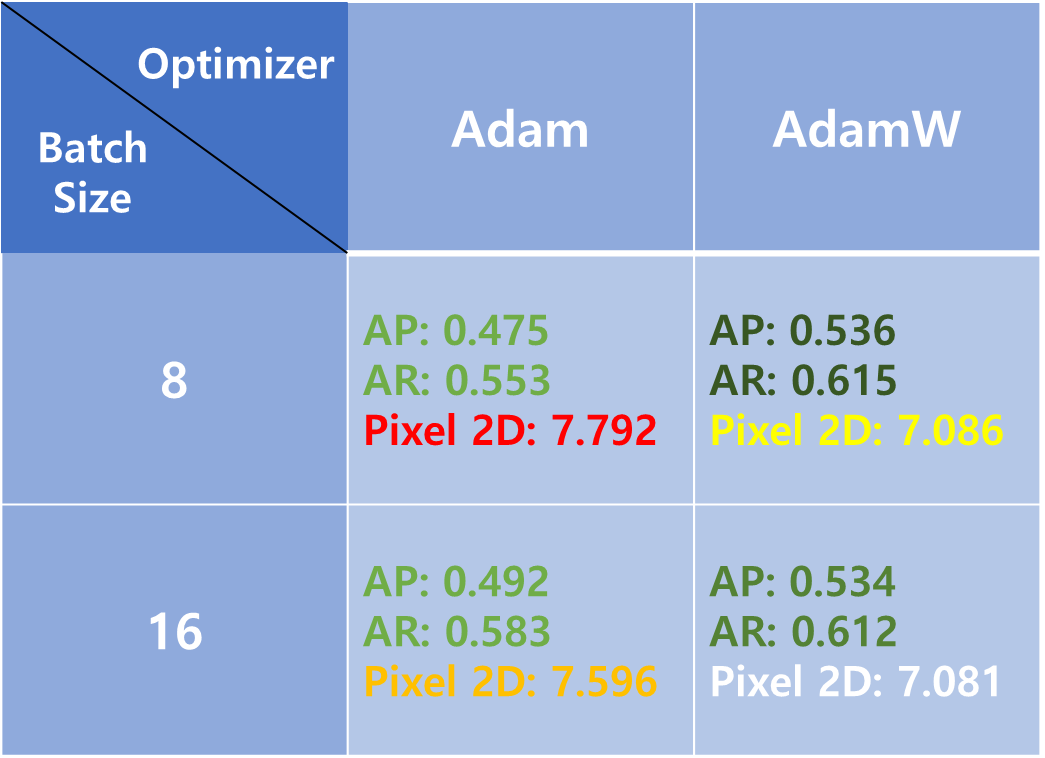

##### Result of Trial 2
##### The accuracy (AP, AR) is the best in AdamW 8 and the loss (Pixel 2D error) is the best in AdamW 16.
##### Therefore, my team decides to use optimizer AdamW and batch size 16 because training speed could be fast if larger batch size is used.

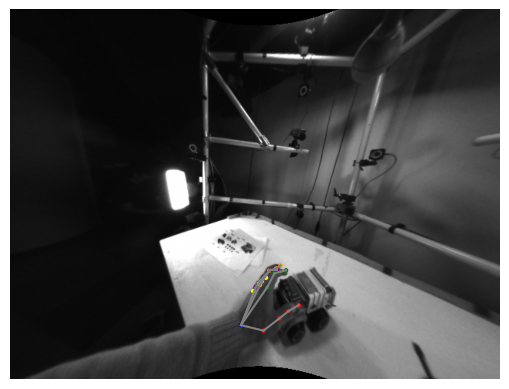

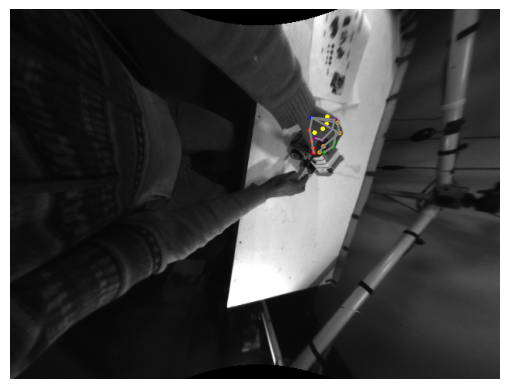

In [20]:
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

def visualize_keypoints(json_file_path, image_path, image_number):
    with open(json_file_path, 'r') as f:
        data = json.load(f)

    # Select data from 'json_file' based on image_number
    keypoints_info = data[image_number]
    
    keypoints = keypoints_info["keypoints"]
    center = keypoints_info["center"]
    scale = keypoints_info["scale"]

    # Load the image
    image = plt.imread(image_path)

    # Create a plot
    plt.imshow(image)
    plt.axis('off')

    # Plot keypoints on the image
    for i, j in zip(range(0, 63, 3), range(0, 63)):
        x, y, score = keypoints[i], keypoints[i + 1], keypoints[i + 2]

        color_cycle = ['red', 'green', 'orange', 'purple', 'yellow', 'blue']
        color = color_cycle[j // 4]

        circle1 = Circle((x, y), radius=2, color=color)
        plt.gca().add_patch(circle1)

    # Skeleton connections based on skeleton_info
    skeleton_info = [
        [1, 2],
        [2, 3],
        [3, 4],
        [4, 21],
        [5, 6],
        [6, 7],
        [7, 8],
        [8, 21],
        [9, 10],
        [10, 11],
        [11, 12],
        [12, 21],
        [13, 14],
        [14, 15],
        [15, 16],
        [16, 21]
    ]

    for connection in skeleton_info:
        start_idx, end_idx = connection
        start_x, start_y, _ = keypoints[(start_idx - 1) * 3: start_idx * 3]
        end_x, end_y, _ = keypoints[(end_idx - 1) * 3: end_idx * 3]
        plt.plot([start_x, end_x], [start_y, end_y], color='gray')

    # Set the aspect ratio and display the plot
    plt.gca().set_aspect('equal')
    plt.show()

# JSON file path
json_file_path = "work_dirs/CLAMP_ViTB_ap10k_256x256_onehand/result_keypoints_onehand_Adam_8.json"

# Image paths and their corresponding image numbers
image_paths = [
    ("data/hands/data/ego_images_rectified/val/nusar-2021_action_both_9012-c07c_9012_user_id_2021-02-01_164345/HMC_84346135_mono10bit/000890.jpg", 5),
    ("data/hands/data/ego_images_rectified/val/nusar-2021_action_both_9012-c07c_9012_user_id_2021-02-01_164345/HMC_84355350_mono10bit/000660.jpg", 320)
]

# Visualize the keypoints and skeleton for each image
for image_path, image_number in image_paths:
    visualize_keypoints(json_file_path, image_path, image_number)

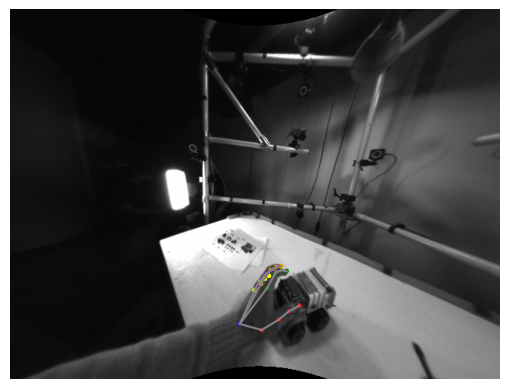

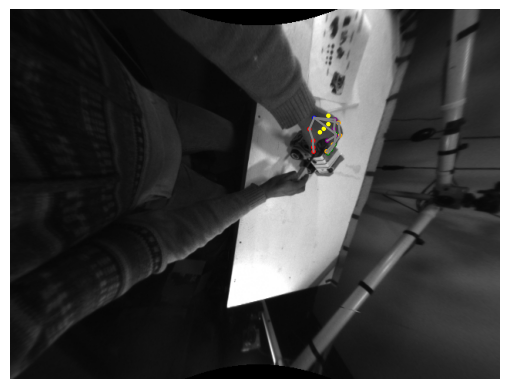

In [21]:
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

def visualize_keypoints(json_file_path, image_path, image_number):
    with open(json_file_path, 'r') as f:
        data = json.load(f)

    # Select data from 'json_file' based on image_number
    keypoints_info = data[image_number]
    
    keypoints = keypoints_info["keypoints"]
    center = keypoints_info["center"]
    scale = keypoints_info["scale"]

    # Load the image
    image = plt.imread(image_path)

    # Create a plot
    plt.imshow(image)
    plt.axis('off')

    # Plot keypoints on the image
    for i, j in zip(range(0, 63, 3), range(0, 63)):
        x, y, score = keypoints[i], keypoints[i + 1], keypoints[i + 2]

        color_cycle = ['red', 'green', 'orange', 'purple', 'yellow', 'blue']
        color = color_cycle[j // 4]

        circle1 = Circle((x, y), radius=2, color=color)
        plt.gca().add_patch(circle1)

    # Skeleton connections based on skeleton_info
    skeleton_info = [
        [1, 2],
        [2, 3],
        [3, 4],
        [4, 21],
        [5, 6],
        [6, 7],
        [7, 8],
        [8, 21],
        [9, 10],
        [10, 11],
        [11, 12],
        [12, 21],
        [13, 14],
        [14, 15],
        [15, 16],
        [16, 21]
    ]

    for connection in skeleton_info:
        start_idx, end_idx = connection
        start_x, start_y, _ = keypoints[(start_idx - 1) * 3: start_idx * 3]
        end_x, end_y, _ = keypoints[(end_idx - 1) * 3: end_idx * 3]
        plt.plot([start_x, end_x], [start_y, end_y], color='gray')

    # Set the aspect ratio and display the plot
    plt.gca().set_aspect('equal')
    plt.show()

# JSON file path
json_file_path = "work_dirs/CLAMP_ViTB_ap10k_256x256_onehand/result_keypoints_onehand_Adam_16.json"

# Image paths and their corresponding image numbers
image_paths = [
    ("data/hands/data/ego_images_rectified/val/nusar-2021_action_both_9012-c07c_9012_user_id_2021-02-01_164345/HMC_84346135_mono10bit/000890.jpg", 5),
    ("data/hands/data/ego_images_rectified/val/nusar-2021_action_both_9012-c07c_9012_user_id_2021-02-01_164345/HMC_84355350_mono10bit/000660.jpg", 320)
]

# Visualize the keypoints and skeleton for each image
for image_path, image_number in image_paths:
    visualize_keypoints(json_file_path, image_path, image_number)

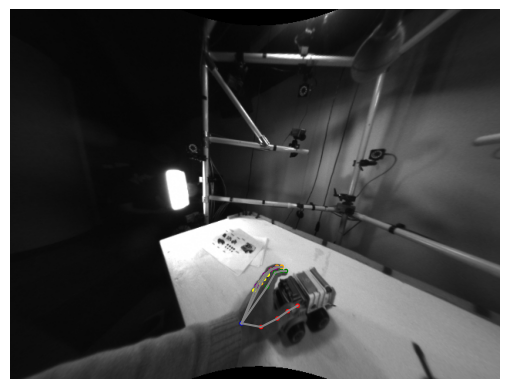

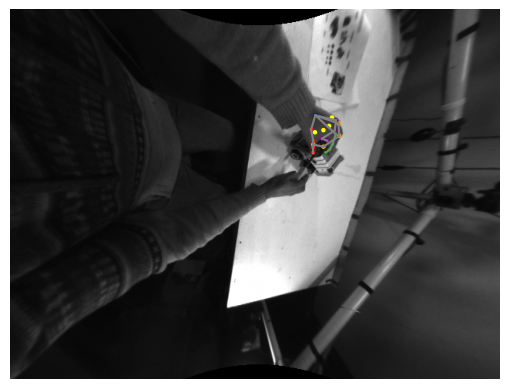

In [22]:
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

def visualize_keypoints(json_file_path, image_path, image_number):
    with open(json_file_path, 'r') as f:
        data = json.load(f)

    # Select data from 'json_file' based on image_number
    keypoints_info = data[image_number]
    
    keypoints = keypoints_info["keypoints"]
    center = keypoints_info["center"]
    scale = keypoints_info["scale"]

    # Load the image
    image = plt.imread(image_path)

    # Create a plot
    plt.imshow(image)
    plt.axis('off')

    # Plot keypoints on the image
    for i, j in zip(range(0, 63, 3), range(0, 63)):
        x, y, score = keypoints[i], keypoints[i + 1], keypoints[i + 2]

        color_cycle = ['red', 'green', 'orange', 'purple', 'yellow', 'blue']
        color = color_cycle[j // 4]

        circle1 = Circle((x, y), radius=2, color=color)
        plt.gca().add_patch(circle1)

    # Skeleton connections based on skeleton_info
    skeleton_info = [
        [1, 2],
        [2, 3],
        [3, 4],
        [4, 21],
        [5, 6],
        [6, 7],
        [7, 8],
        [8, 21],
        [9, 10],
        [10, 11],
        [11, 12],
        [12, 21],
        [13, 14],
        [14, 15],
        [15, 16],
        [16, 21]
    ]

    for connection in skeleton_info:
        start_idx, end_idx = connection
        start_x, start_y, _ = keypoints[(start_idx - 1) * 3: start_idx * 3]
        end_x, end_y, _ = keypoints[(end_idx - 1) * 3: end_idx * 3]
        plt.plot([start_x, end_x], [start_y, end_y], color='gray')

    # Set the aspect ratio and display the plot
    plt.gca().set_aspect('equal')
    plt.show()

# JSON file path
json_file_path = "work_dirs/CLAMP_ViTB_ap10k_256x256_onehand/result_keypoints_onehand_AdamW_8.json"

# Image paths and their corresponding image numbers
image_paths = [
    ("data/hands/data/ego_images_rectified/val/nusar-2021_action_both_9012-c07c_9012_user_id_2021-02-01_164345/HMC_84346135_mono10bit/000890.jpg", 5),
    ("data/hands/data/ego_images_rectified/val/nusar-2021_action_both_9012-c07c_9012_user_id_2021-02-01_164345/HMC_84355350_mono10bit/000660.jpg", 320)
]

# Visualize the keypoints and skeleton for each image
for image_path, image_number in image_paths:
    visualize_keypoints(json_file_path, image_path, image_number)

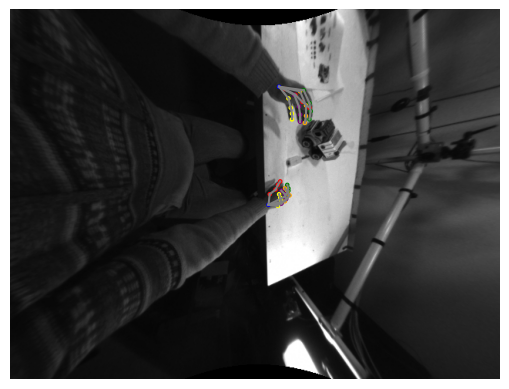

In [24]:
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

def visualize_keypoints(json_file_path, image_path):
    with open(json_file_path, 'r') as f:
        data = json.load(f)

    # Select data from 'json_file'
    keypoints_info = data[250] # Change image number
    
    keypoints = keypoints_info["keypoints"]
    center = keypoints_info["center"]
    scale = keypoints_info["scale"]

    # Load the image
    image = plt.imread(image_path)

    # Create a plot
    plt.imshow(image)
    plt.axis('off')

    # Plot keypoints on the image
    for i, j in zip(range(0, 63, 3), range(0, 63)):
        x, y, score = keypoints[i], keypoints[i + 1], keypoints[i + 2]

        color_cycle = ['red', 'green', 'orange', 'purple', 'yellow', 'blue']
        color = color_cycle[j // 4]

        circle1 = Circle((x, y), radius=2, color=color)
        plt.gca().add_patch(circle1)

    for i, j in zip(range(63, 126, 3), range(63, 126)):
        x, y, score = keypoints[i], keypoints[i + 1], keypoints[i + 2]

        color_cycle = ['red', 'green', 'orange', 'purple', 'yellow', 'blue']
        color = color_cycle[(j-63) // 4]

        circle1 = Circle((x, y), radius=2, color=color)
        plt.gca().add_patch(circle1)

    # Skeleton connections based on skeleton_info
    skeleton_info = [
        [1, 2],
        [2, 3],
        [3, 4],
        [4, 21],
        [5, 6],
        [6, 7],
        [7, 8],
        [8, 21],
        [9, 10],
        [10, 11],
        [11, 12],
        [12, 21],
        [13, 14],
        [14, 15],
        [15, 16],
        [16, 21],
        [17, 18],
        [18, 19],
        [19, 20],
        [20, 21],
        [22, 23],
        [23, 24],
        [24, 25],
        [25, 42],
        [26, 27],
        [27, 28],
        [28, 29],
        [29, 42],
        [30, 31],
        [31, 32],
        [32, 33],
        [33, 42],
        [34, 35],
        [35, 36],
        [36, 37],
        [37, 42],
        [38, 39],
        [39, 40],
        [40, 41],
        [41, 42]
    ]

    for connection in skeleton_info:
        start_idx, end_idx = connection
        start_x, start_y, _ = keypoints[(start_idx - 1) * 3 : start_idx * 3]
        end_x, end_y, _ = keypoints[(end_idx - 1) * 3 : end_idx * 3]
        plt.plot([start_x, end_x], [start_y, end_y], color='gray')

    # Set the aspect ratio and display the plot
    plt.gca().set_aspect('equal')
    plt.show()

# JSON file path
json_file_path = "work_dirs/CLAMP_ViTB_ap10k_256x256_twohands/result_keypoints_twohands.json"

# Image path (Make sure the image corresponding to image_id: 222 is available)
image_path = "data/hands/data/ego_images_rectified/val/nusar-2021_action_both_9012-c07c_9012_user_id_2021-02-01_164345/HMC_84355350_mono10bit/000520.jpg"

# Visualize the keypoints and skeleton
visualize_keypoints(json_file_path, image_path)

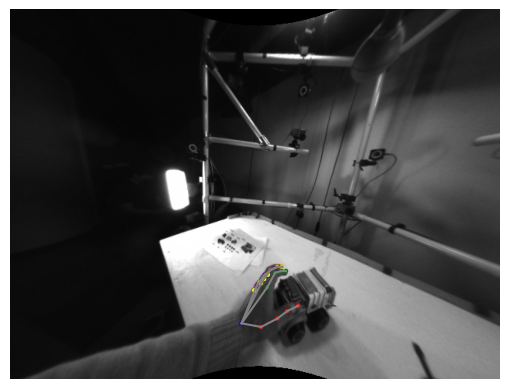

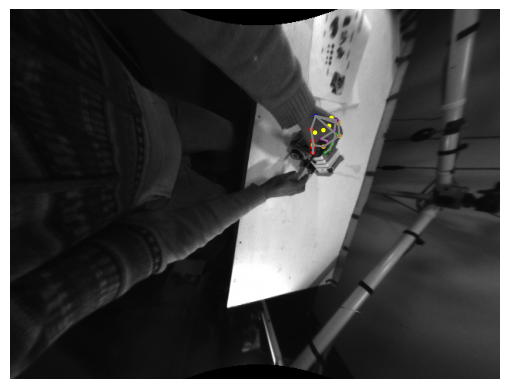

In [23]:
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

def visualize_keypoints(json_file_path, image_path, image_number):
    with open(json_file_path, 'r') as f:
        data = json.load(f)

    # Select data from 'json_file' based on image_number
    keypoints_info = data[image_number]
    
    keypoints = keypoints_info["keypoints"]
    center = keypoints_info["center"]
    scale = keypoints_info["scale"]

    # Load the image
    image = plt.imread(image_path)

    # Create a plot
    plt.imshow(image)
    plt.axis('off')

    # Plot keypoints on the image
    for i, j in zip(range(0, 63, 3), range(0, 63)):
        x, y, score = keypoints[i], keypoints[i + 1], keypoints[i + 2]

        color_cycle = ['red', 'green', 'orange', 'purple', 'yellow', 'blue']
        color = color_cycle[j // 4]

        circle1 = Circle((x, y), radius=2, color=color)
        plt.gca().add_patch(circle1)

    # Skeleton connections based on skeleton_info
    skeleton_info = [
        [1, 2],
        [2, 3],
        [3, 4],
        [4, 21],
        [5, 6],
        [6, 7],
        [7, 8],
        [8, 21],
        [9, 10],
        [10, 11],
        [11, 12],
        [12, 21],
        [13, 14],
        [14, 15],
        [15, 16],
        [16, 21]
    ]

    for connection in skeleton_info:
        start_idx, end_idx = connection
        start_x, start_y, _ = keypoints[(start_idx - 1) * 3: start_idx * 3]
        end_x, end_y, _ = keypoints[(end_idx - 1) * 3: end_idx * 3]
        plt.plot([start_x, end_x], [start_y, end_y], color='gray')

    # Set the aspect ratio and display the plot
    plt.gca().set_aspect('equal')
    plt.show()

# JSON file path
json_file_path = "work_dirs/CLAMP_ViTB_ap10k_256x256_onehand/result_keypoints_onehand_AdamW_16.json"

# Image paths and their corresponding image numbers
image_paths = [
    ("data/hands/data/ego_images_rectified/val/nusar-2021_action_both_9012-c07c_9012_user_id_2021-02-01_164345/HMC_84346135_mono10bit/000890.jpg", 5),
    ("data/hands/data/ego_images_rectified/val/nusar-2021_action_both_9012-c07c_9012_user_id_2021-02-01_164345/HMC_84355350_mono10bit/000660.jpg", 320)
]

# Visualize the keypoints and skeleton for each image
for image_path, image_number in image_paths:
    visualize_keypoints(json_file_path, image_path, image_number)

##### 3-2-2-3. Trial 3 (Two Hands)

```python
_base_ = ['../../../../_base_/datasets/interhand_twohands.py']
log_level = 'INFO'
load_from = None
resume_from = None
dist_params = dict(backend='nccl')
workflow = [('train', 1)]
checkpoint_config = dict(interval=10)
evaluation = dict(interval=10, metric='mAP', save_best='AP')

optimizer = dict(type='AdamW',
                 lr=5e-4,
                 weight_decay=0.0001,
                 paramwise_cfg=dict(custom_keys={'text_encoder': dict(lr_mult=0.0),
                                                 'backbone': dict(lr_mult=0.1),
                                                 'norm': dict(decay_mult=0.)})
)
optimizer_config = dict(grad_clip=None)
# learning policy
lr_config = dict(
    policy='step',
    warmup='linear',
    warmup_iters=500,
    warmup_ratio=0.001,
    step=[170, 200])
total_epochs = 210
log_config = dict(
    interval=1,
    hooks=[
        dict(type='TextLoggerHook'),
    ])

channel_cfg = dict(
    num_output_channels=42,
    dataset_joints=42,
    dataset_channel=[
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41],
    ],
    inference_channel=[
        0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41
    ])

# model settings
model = dict(
    type='CLAMP',
    clip_pretrained='pretrained/ViT-B-16.pt',
    context_length=11,
    text_dim=512,
    score_concat_index=3,
    visual_dim=512,
    CL_ratio=0.0005,
    class_names=['right thumb tip', 'right thumb proximal joint', 'right thumb intermediate joint', 'right thumb base joint',
                'right index tip', 'right index proximal joint', 'right index intermediate joint', 'right index base joint',
                'right middle tip', 'right middle proximal joint', 'right middle intermediate joint', 'right middle base joint',
                'right ring tip', 'right ring proximal joint', 'right ring intermediate joint', 'right ring base joint',
                'right little tip', 'right little proximal joint', 'right little intermediate joint', 'right little base joint',
                'right wrist', 'left thumb tip', 'left thumb proximal joint', 'left thumb intermediate joint', 'left thumb base joint',
                'left index tip', 'left index proximal joint', 'left index intermediate joint', 'left index base joint',
                'left middle tip', 'left middle proximal joint', 'left middle intermediate joint', 'left middle base joint',
                'left ring tip', 'left ring proximal joint', 'left ring intermediate joint', 'left ring base joint',
                'left little tip', 'left little proximal joint', 'left little intermediate joint', 'left little base joint',
                'left wrist'],
    text_encoder=dict(
        type='CLIPTextContextEncoder',
        context_length=13,
        embed_dim=512,
        transformer_width=512,
        transformer_heads=8,
        transformer_layers=12,
        pretrained='pretrained/ViT-B-16.pt',
        style='pytorch'),
    prompt_encoder=dict(
        type='PromptEncoderWithoutPositionemb',
        prompt_num=42,
        transformer_width=512,
        transformer_heads=8,
        transformer_layers=1,
        embed_dim=512,
        style='pytorch'),
    context_decoder=dict(
        type='ContextDecoder',
        transformer_width=256,
        transformer_heads=4,
        transformer_layers=3,
        visual_dim=512,
        dropout=0.1,
        outdim=512,
        style='pytorch'),
    backbone=dict(
        type='CLIPVisionTransformer',
        debug=False,
        use_fpn=False,
        patch_size=16,
        width=768,
        output_dim=512,
        get_embeddings=True,
        drop_path_rate=0.4,
        layers=12,
        input_resolution=256,
        style='pytorch'),
    keypoint_head=dict(
        type='TopdownHeatmapSimpleHead',
        num_deconv_layers=2,
        num_deconv_filters=(256, 256),
        num_deconv_kernels=(4, 4),
        in_channels=810, #768+42
        out_channels=channel_cfg['num_output_channels'],
        loss_keypoint=dict(type='JointsMSELoss', use_target_weight=True, loss_weight=1.0)),
    upconv_head=dict( #for score map only
        type='TopdownHeatmapSimpleHead',
        num_deconv_layers=2,
        num_deconv_filters=(42, 42),
        num_deconv_kernels=(4, 4),
        in_channels=42,
        out_channels=channel_cfg['num_output_channels'],
        loss_keypoint=dict(type='JointsMSELoss', use_target_weight=True, loss_weight=2.0)),
    identity_head=dict(
        type='IdentityHead',
        loss_keypoint=dict(type='JointsMSELoss', use_target_weight=True, loss_weight=2.0)),
    train_cfg=dict(),
    test_cfg=dict(
        flip_test=True,
        post_process='default',
        shift_heatmap=True,
        modulate_kernel=11))

data_cfg = dict(
    image_size=[256, 256],
    heatmap_size=[64, 64],
    num_output_channels=channel_cfg['num_output_channels'],
    num_joints=channel_cfg['dataset_joints'],
    dataset_channel=channel_cfg['dataset_channel'],
    inference_channel=channel_cfg['inference_channel'],
    soft_nms=False,
    nms_thr=1.0,
    oks_thr=0.9,
    vis_thr=0.2,
    use_gt_bbox=True,
    det_bbox_thr=0.0,
    bbox_file='',
)

train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='TopDownRandomFlip', flip_prob=0.5),
    dict(
        type='TopDownHalfBodyTransform',
        num_joints_half_body=8,
        prob_half_body=0.3),
    dict(
        type='TopDownGetRandomScaleRotation', rot_factor=40, scale_factor=0.5),
    dict(type='TopDownAffine'),
    dict(type='ToTensor'),
    dict(
        type='NormalizeTensor',
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]),
    dict(type='TopDownGenerateTarget', sigma=2, downtarget=True, downsize=16),
    dict(
        type='Collect',
        keys=['img', 'target', 'target_weight'],
        meta_keys=[
            'image_file', 'joints_3d', 'joints_3d_visible', 'center', 'scale',
            'rotation', 'bbox_score', 'flip_pairs'
        ]),
]

val_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='TopDownAffine'),
    dict(type='ToTensor'),
    dict(
        type='NormalizeTensor',
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]),
    dict(
        type='Collect',
        keys=['img'],
        meta_keys=[
            'image_file', 'center', 'scale', 'rotation', 'bbox_score',
            'flip_pairs'
        ]),
]

test_pipeline = val_pipeline

data_root = 'data/hands'
data = dict(
    samples_per_gpu=16,
    workers_per_gpu=4,
    val_dataloader=dict(samples_per_gpu=16),
    test_dataloader=dict(samples_per_gpu=16),
    persistent_workers=True,
    pin_memory=False,
    train=dict(
        type='AnimalAP10KDataset',
        ann_file=f'{data_root}/annotations/assemblyhands_train_ego_data_v1-1_twohands.json',
        img_prefix=f'{data_root}/data/',
        data_cfg=data_cfg,
        pipeline=train_pipeline,
        dataset_info={{_base_.dataset_info}}),
    val=dict(
        type='AnimalAP10KDataset',
        ann_file=f'{data_root}/annotations/assemblyhands_val_ego_data_v1-1_twohands.json',
        img_prefix=f'{data_root}/data/',
        data_cfg=data_cfg,
        pipeline=val_pipeline,
        dataset_info={{_base_.dataset_info}}),
    test=dict(
        type='AnimalAP10KDataset',
        ann_file=f'{data_root}/annotations/assemblyhands_test_ego_data_v1-1_twohands.json',
        img_prefix=f'{data_root}/data/',
        data_cfg=data_cfg,
        pipeline=val_pipeline,
        dataset_info={{_base_.dataset_info}}),
)
```

In [25]:
!bash tools/dist_test.sh configs/animal/2d_kpt_sview_rgb_img/topdown_heatmap/ap10k/CLAMP_ViTB_ap10k_256x256_twohands.py work_dirs/CLAMP_ViTB_ap10k_256x256/epoch_210_twohands.pth 1 "0"

/home/jupyter/CLAMP/mmcv/mmcv/cnn/bricks/transformer.py:28: UserWarning: Fail to import ``MultiScaleDeformableAttention`` from ``mmcv.ops.multi_scale_deform_attn``, You should install ``mmcv-full`` if you need this module. 
  warnings.warn('Fail to import ``MultiScaleDeformableAttention`` from '
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
=> num_images: 500
=> load 500 samples
Resize the pos_embed shape from torch.Size([197, 768]) to torch.Size([257, 768])
/opt/conda/envs/clamp/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
[] [] are misaligned params in vision transformer
positional_embedding is tuncated from 77 to 13
[] [] are misaligned params in te

In [27]:
import json
import numpy as np
import torch

# Actual file path
actual_json_file_path = "data/hands/annotations/assemblyhands_val_ego_data_v1-1_twohands.json"

# Predicted file path
predicted_json_file_path = "work_dirs/CLAMP_ViTB_ap10k_256x256_twohands/result_keypoints_twohands.json"

# Load actual and predicted skeleton points from JSON files
with open(actual_json_file_path, 'r') as f:
    actual_data = json.load(f)

with open(predicted_json_file_path, 'r') as f:
    predicted_data = json.load(f)

# Initialize arrays to store results
mpjpe_2d_values = []

for entry_idx in range(len(actual_data["annotations"])):
    actual_skeleton = np.array(actual_data["annotations"][entry_idx]["keypoints"])
    predicted_skeleton = np.array(predicted_data[entry_idx]["keypoints"])

    actual_skeleton = actual_skeleton.reshape((-1, 42, 3))
    predicted_skeleton = predicted_skeleton.reshape((-1, 42, 3))

    actual_skeleton_tensor = torch.tensor(actual_skeleton)
    predicted_skeleton_tensor = torch.tensor(predicted_skeleton)

    excluded_indices = torch.where((actual_skeleton_tensor == -1.0000e+05).any(dim=2))[1]

    num_joints = list(range(actual_skeleton_tensor.size(1)))
    nouse_joints = list(excluded_indices.numpy())
    use_joints = [item for item in num_joints if item not in nouse_joints]

    actual_skeleton_tensor = actual_skeleton_tensor[:, use_joints, :]
    predicted_skeleton_tensor = predicted_skeleton_tensor[:, use_joints, :]

    uv_errors = torch.sqrt(((predicted_skeleton_tensor - actual_skeleton_tensor)[:, :, :2] ** 2).sum(dim=-1)).mean(dim=-1).cpu().numpy()
    mpjpe_2d = np.mean(uv_errors)
    mpjpe_2d_values.append(mpjpe_2d)

# Calculate and print the overall metrics
mean_mpjpe_2d = np.mean(mpjpe_2d_values)
print("Pixel 2D:", mean_mpjpe_2d)

Pixel 2D: 9.016877608729986


##### Result of Trial 3
##### The accuracy and the loss of two hands are worse than one hand because my team predicts that it will be more hard control in bounding box for two hands.